# Casestudy CRC :  SRM colorectal cancer data

This is case study CRC in  in this paper. The dataset is available at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4568950/. 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import set_matplotlib_formats
from matplotlib.lines import Line2D
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection
import json
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.join(os.path.dirname(current_dir), 'code'))
from utility import show_protein_abundance_features
from evaluate import plot_corr
set_matplotlib_formats("svg")


/var/folders/sp/pn9txhp11mn2pyld318tpy080000gn/T/ipykernel_49079/2427887520.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


Plasma samples were subjected to parallel N-glycoprotein
extraction in a 96-well format, followed by targeted Selected Reaction Monitoring (SRM)
quantification of 67 candidate proteins by SRM. PSMs were summarized into protein-level
summaries by MSstatsTMT. 

### Get pilot/historical data from past similar experiment

In [13]:
data = pd.read_csv('../casestudy/crc/data/crc_silvia_data.csv')
data.head()

,A1AG2,AFM,AHSG,ANT3,AOC3,APOB,ATRN,BTD,C20orf3,CADM1,...,Q5JNX2,SERPINA1,SERPINA3,SERPINA6,SERPINA7,THBS1,TIMP1,VTN,VWF,Condition
0,14.238157,16.103019,19.951792,17.207936,10.032169,15.544774,14.383388,16.283071,10.667779,9.653029,...,19.028130,18.061091,14.218036,15.796849,13.581848,13.995686,11.578754,12.081352,10.661031,CRC
1,15.024111,16.020714,19.715919,17.297900,9.034144,15.131883,13.981723,16.249189,10.703279,9.624991,...,19.862536,17.610188,14.832327,15.815397,13.138445,13.707714,11.960974,12.838407,10.778432,CRC
2,15.631364,16.143800,19.710849,17.596254,10.381880,15.955302,14.635355,16.499158,11.183873,10.323191,...,19.501773,18.539972,15.308726,16.401770,13.742330,15.636962,12.155842,12.313155,11.185271,CRC
3,15.401365,16.276415,19.704377,17.422504,9.502960,15.714932,14.060700,16.277732,9.972982,9.994209,...,19.984664,17.401414,14.254241,16.310491,13.936894,15.517268,12.379265,10.679166,10.887855,CRC
4,16.003158,16.958207,20.420334,17.988199,9.648502,16.247330,14.203595,16.541422,12.581556,9.607492,...,20.467453,17.448008,16.231911,16.485833,14.167134,15.129106,12.169116,14.506106,11.254175,CRC


## Evaluation. Evaluating the realism of simulated data

#### Visual Metrics

#### Pairplot Experimental data

In [ ]:
sns.set_style("white")
sns.pairplot(data[["CP","PON1","SERPINA3","LRG1","TIMP1","Condition"]], hue="Condition",height=1.5, aspect=0.8)

#### Pairplot Per-protein data

In [ ]:
simpp0 = pd.read_csv('../casestudy/crc/perprotein/crc0_pp_0.csv')
simpp1 = pd.read_csv('../casestudy/crc/perprotein/crc1_pp_0.csv')
merged_df = pd.merge(simpp0, simpp1, how='outer', indicator=True)
merged_df['Condition'] = merged_df['_merge'].map({ 'left_only': 0, 'right_only': 1})
merged_df = merged_df.drop('_merge', axis=1)
sns.pairplot(data[["CP","PON1","SERPINA3","LRG1","TIMP1","Condition"]], hue="Condition",height=1.5, aspect=0.8)

#### Pairplot TVAE data

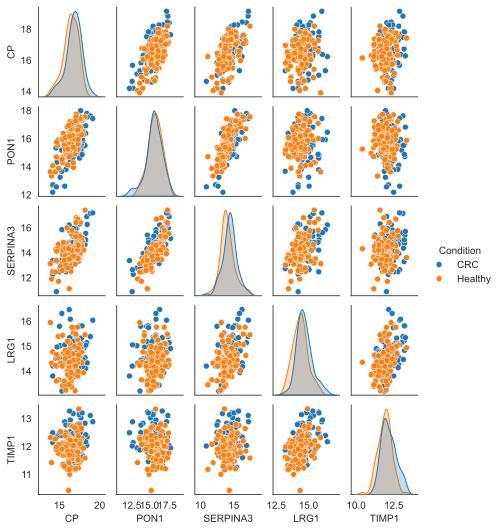

In [7]:
simtvae0 = pd.read_csv('../casestudy/crc/tvae/crc0_tvae_0.csv')
simtvae1 = pd.read_csv('../casestudy/crc/tvae/crc1_tvae_0.csv')
merged_df = pd.merge(simtvae0, simtvae1, how='outer', indicator=True)
merged_df['Condition'] = merged_df['_merge'].map({ 'left_only': 0, 'right_only': 1})
merged_df = merged_df.drop('_merge', axis=1)
sns.pairplot(data[["CP","PON1","SERPINA3","LRG1","TIMP1","Condition"]], hue="Condition",height=1.5, aspect=0.8)

#### Pairplot Copula data

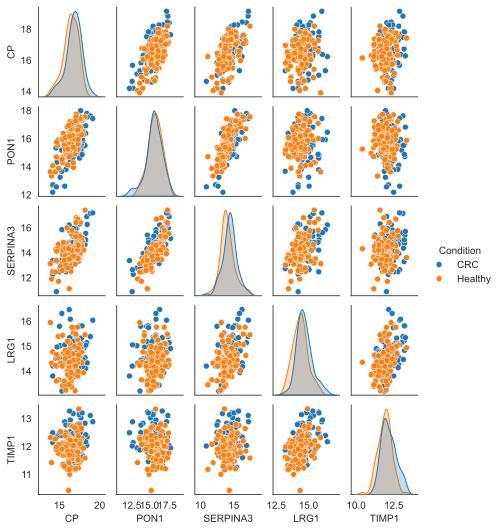

In [9]:
simco0 = pd.read_csv('../casestudy/crc/copula/crc0_gm_copula_0.csv')
simco1 = pd.read_csv('../casestudy/crc/copula/crc1_gm_copula_0.csv')
merged_df = pd.merge(simco0, simco1, how='outer', indicator=True)
merged_df['Condition'] = merged_df['_merge'].map({ 'left_only': 0, 'right_only': 1})
merged_df = merged_df.drop('_merge', axis=1)
sns.pairplot(data[["CP","PON1","SERPINA3","LRG1","TIMP1","Condition"]], hue="Condition",height=1.5, aspect=0.8)

#### Real correlation for Experimental healthy

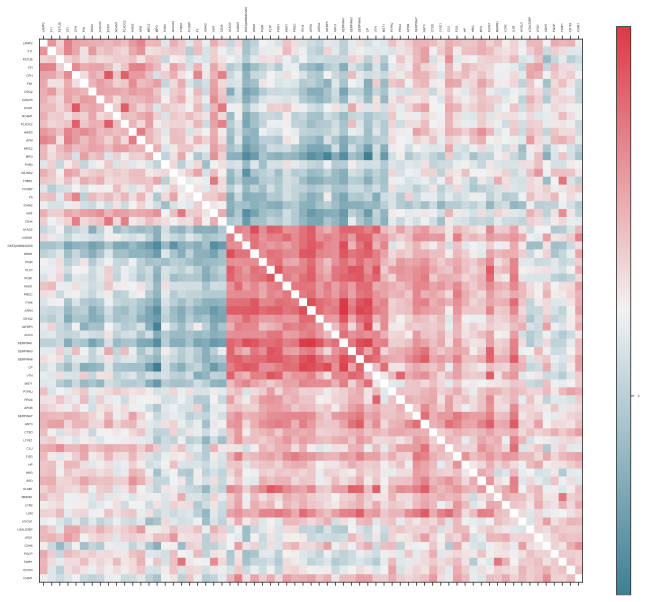

In [21]:
df = data
df_with_0 = df[df['Condition'] == 'Healthy'].drop(columns='Condition')
df_with_1 = df[df['Condition'] == 'CRC'].drop(columns='Condition')
df = df_with_0
X = df.corr().values
X[np.isnan(X)]= 0
d = sch.distance.pdist(X)   
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)
plot_corr(df, size=10,font_scale=0.5)

#### Correlation for Per-protein healthy

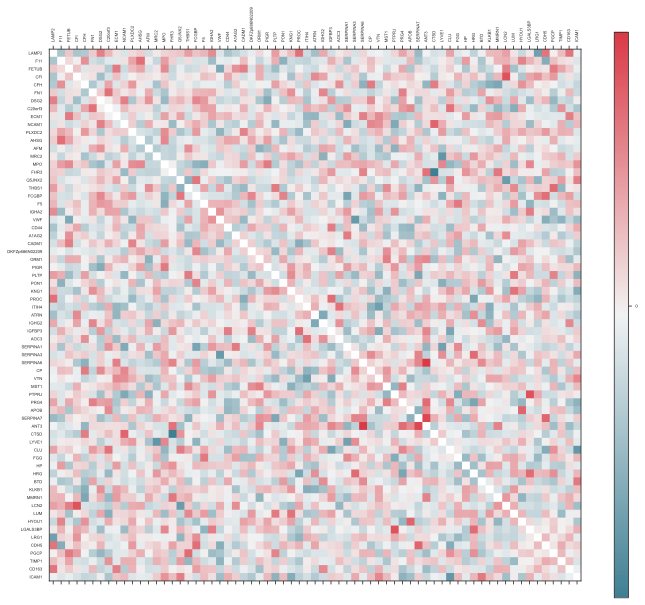

In [22]:
simpp0 = simpp0.reindex(columns, axis=1)
plot_corr(simpp0,size=10)

#### Correlation for TVAE healthy

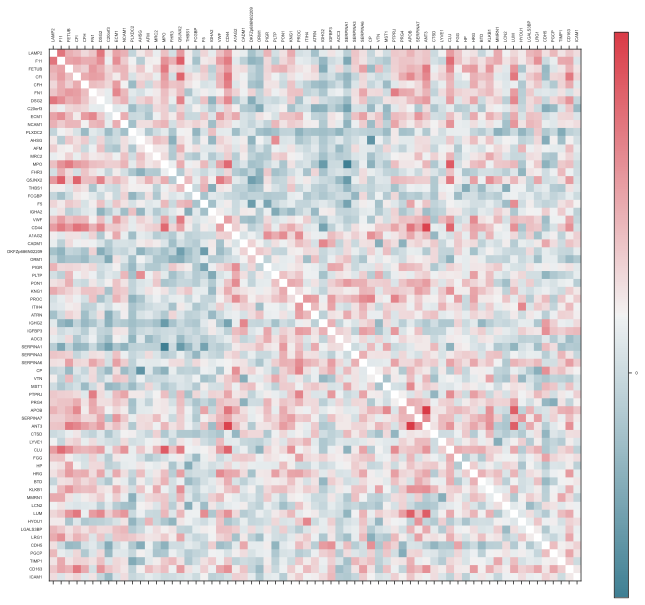

In [23]:
simtvae0 = simtvae0.reindex(columns, axis=1)
plot_corr(simtvae0,size=10)

#### Correlation for Copula healthy

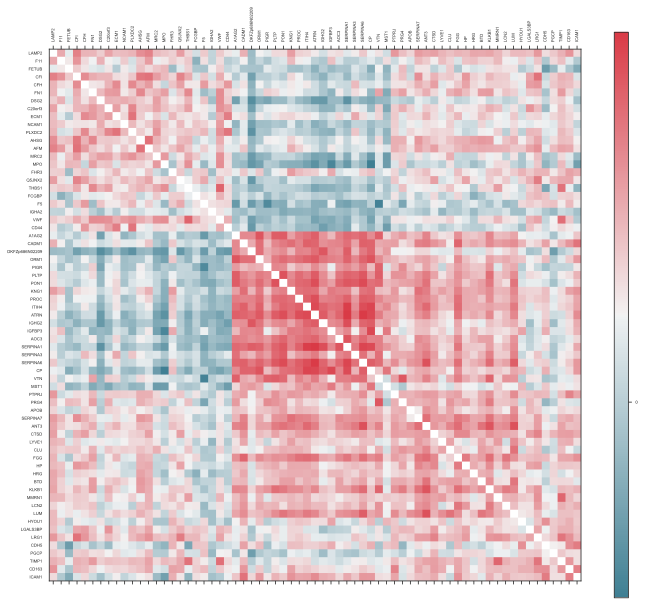

In [24]:
simco0 = simco0.reindex(columns, axis=1)
plot_corr(simco0,size=10)

#### Correlation for experimental data CRC

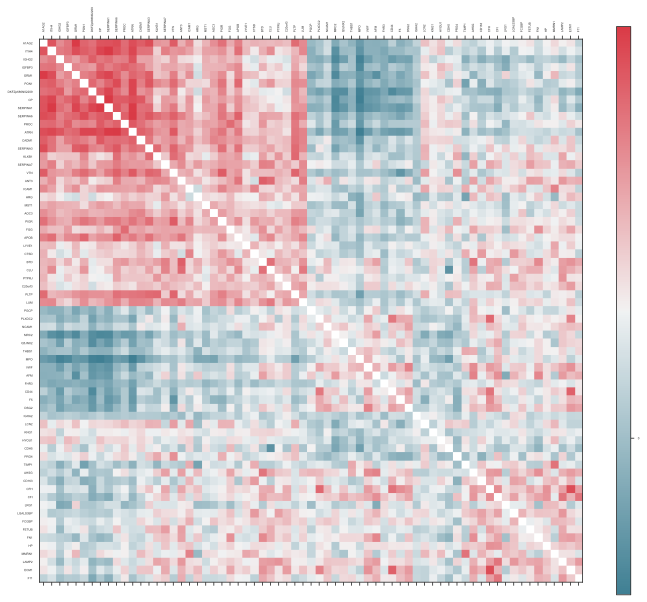

In [25]:
df = df_with_1
X = df.corr().values
X[np.isnan(X)]= 0
d = sch.distance.pdist(X)   
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)
plot_corr(df, size=10,font_scale=0.5)

#### Correlation for Per-protein CRC

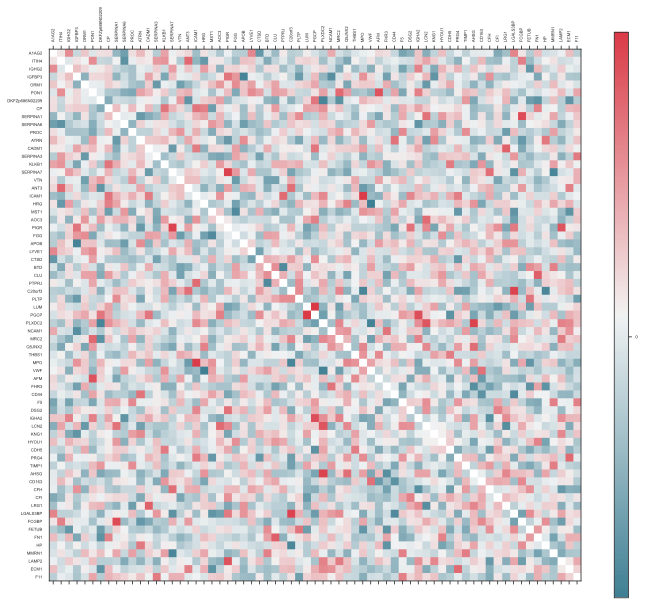

In [26]:
simpp1 = simpp1.reindex(columns, axis=1)
plot_corr(simpp1,size=10)

#### Correlation for TVAE CRC

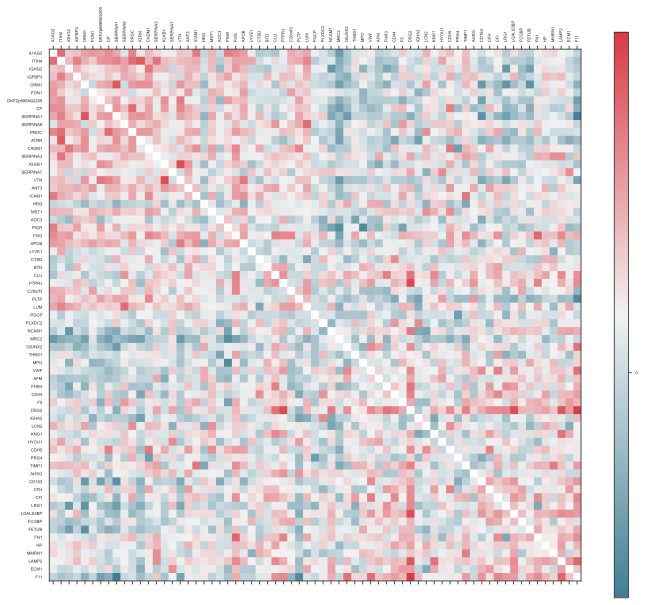

In [27]:
simtvae1 = simtvae1.reindex(columns, axis=1)
plot_corr(simtvae1,size=10)


#### Correlation for Copula CRC

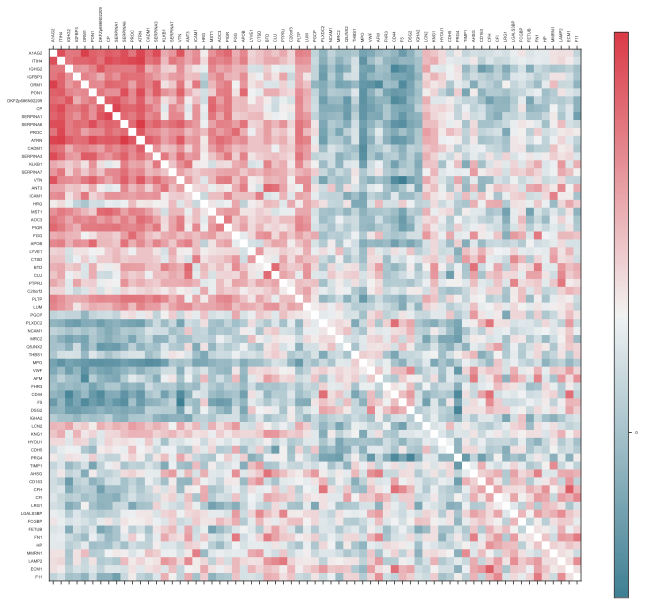

In [28]:
simco1 = simco1.reindex(columns, axis=1)
plot_corr(simco1,size=10)

## Planning. Use simulations to plan future experiments


#### Class Prediction

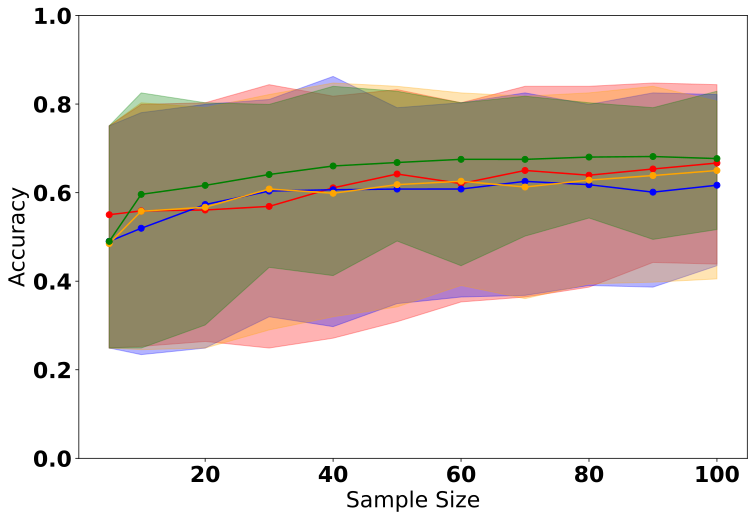

In [2]:
rfaccuracy = pd.read_csv('../casestudy/crc/crcrfaccuracynorm.csv')

crc_data_val = rfaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.ylim(0, 1) 

plt.show()


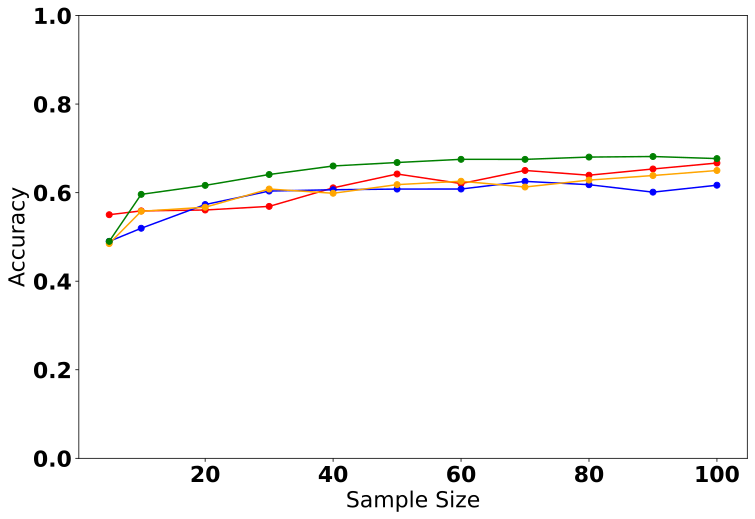

In [5]:
crc_data_val = rfaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
# plt.title('Accuracy vs Sample Size for Different Methods')
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
# plt.grid(True)
plt.ylim(0, 1) 

plt.show()


##### Class Discovery

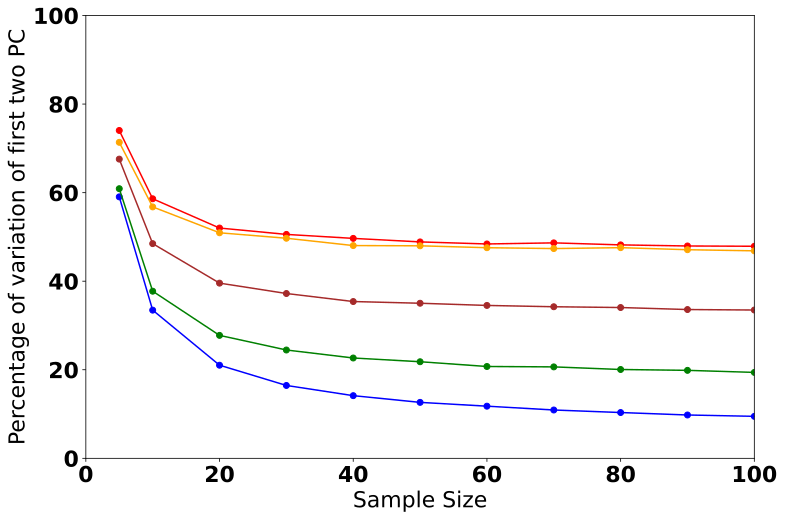

In [6]:
pcaaccuracy = pd.read_csv('../casestudy/crc/crcpca.csv')
crc_data_val = pcaaccuracy
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)

plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy v'],label='Experimental Validation',marker='o', color='brown')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min v'], crc_data_val['max v'], color='brown', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
# plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Percentage of variation of first two PC')

plt.ylim(0, 100)
plt.xlim(0,100)
plt.show()


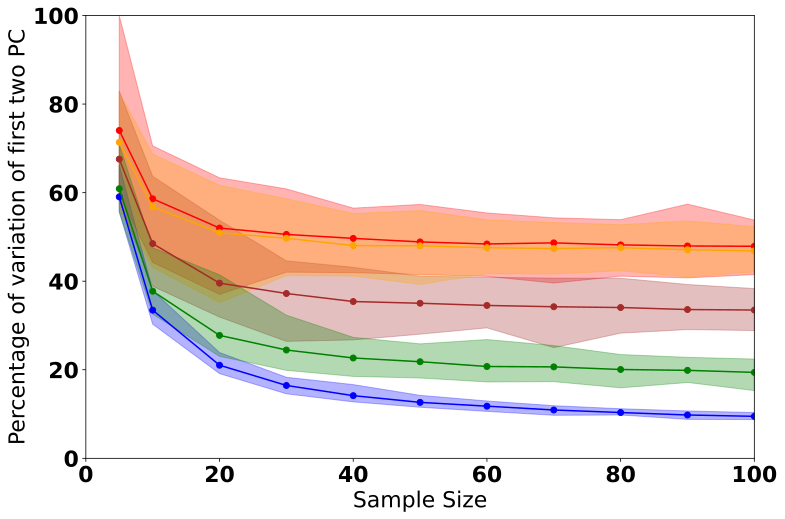

In [7]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)

plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy v'],label='Experimental Validation',marker='o', color='brown')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min v'], crc_data_val['max v'], color='brown', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Percentage of variation of first two PC')

plt.ylim(0, 100)
plt.xlim(0,100)
plt.show()


##### Class Comparison

In [15]:
adjusted_p_values = {}
adjusted_p_values_pp = {}
adjusted_p_values_co = {}
adjusted_p_values_tvae = {}
dicts = {'real_adjust': adjusted_p_values, 'pp_adjust': adjusted_p_values_pp, 'co_adjust': adjusted_p_values_co, 'tvae_adjust': adjusted_p_values_tvae}  # Add more dictionaries as needed

# Load each JSON file and update the corresponding dictionary
for key, value in dicts.items():
    file_path = f'../casestudy/crc/pval/{key}.json'
    with open(file_path, 'r') as json_file:
        value.update(json.load(json_file))

sample_sizes=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

real = []
pp = []
co = []
tvae = []
realmin = []
realmax = []
ppmin = []
ppmax = []
comin = []
comax = []
tvaemin = []
tvaemax = []

col = 'CP'

for s in sample_sizes:
    s = str(s)
    real.append(np.median(adjusted_p_values[s][col]))
    pp.append(np.median(adjusted_p_values_pp[s][col]))
    co.append(np.median(adjusted_p_values_co[s][col]))
    tvae.append(np.median(adjusted_p_values_tvae[s][col]))
    realmin.append(np.min(adjusted_p_values[s][col]))
    realmax.append(np.max(adjusted_p_values[s][col]))
    ppmin.append(np.min(adjusted_p_values_pp[s][col]))
    ppmax.append(np.max(adjusted_p_values_pp[s][col]))
    comin.append(np.min(adjusted_p_values_co[s][col]))
    comax.append(np.max(adjusted_p_values_co[s][col])) 
    tvaemin.append(np.min(adjusted_p_values_tvae[s][col]))
    tvaemax.append(np.max(adjusted_p_values_tvae[s][col]))


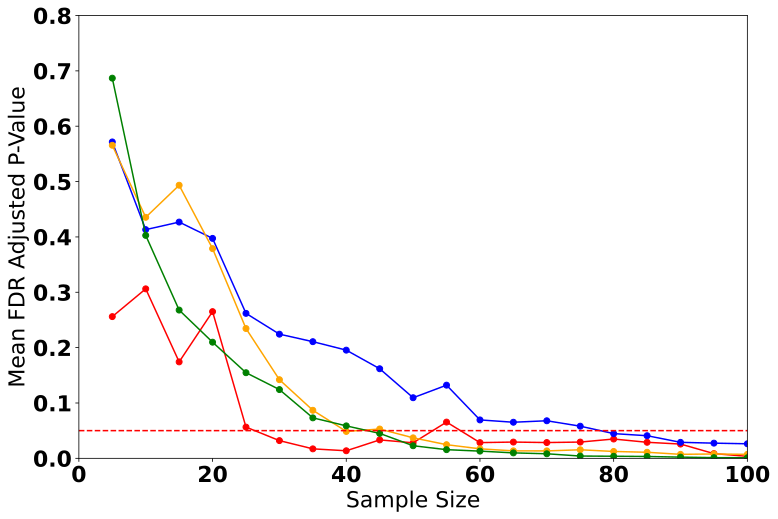

In [16]:
plt.figure(figsize=(12, 8))
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.plot(sample_sizes, real, marker='o', label='Experimental', color='red', linestyle='-')
# plt.fill_between(sample_sizes, realmin, realmax, color='red', alpha=0.3)

plt.plot(sample_sizes, pp, marker='o', label='Per-Protein', color='blue', linestyle='-')
# plt.fill_between(sample_sizes, ppmin, ppmax, color='blue', alpha=0.3)

plt.plot(sample_sizes, co, marker='o', label='Copula', color='orange', linestyle='-')
# plt.fill_between(sample_sizes, comin, comax, color='orange', alpha=0.3)

plt.plot(sample_sizes, tvae, marker='o', label='TVAE', color='green', linestyle='-')
# plt.fill_between(sample_sizes, tvaemin, tvaemax, color='green', alpha=0.3)

plt.axhline(y=0.05, color='red', linestyle='--')

plt.xlabel('Sample Size')
plt.ylabel('Mean FDR Adjusted P-Value')

plt.ylim(0.0,0.8)
plt.xlim(0,100)
plt.show()

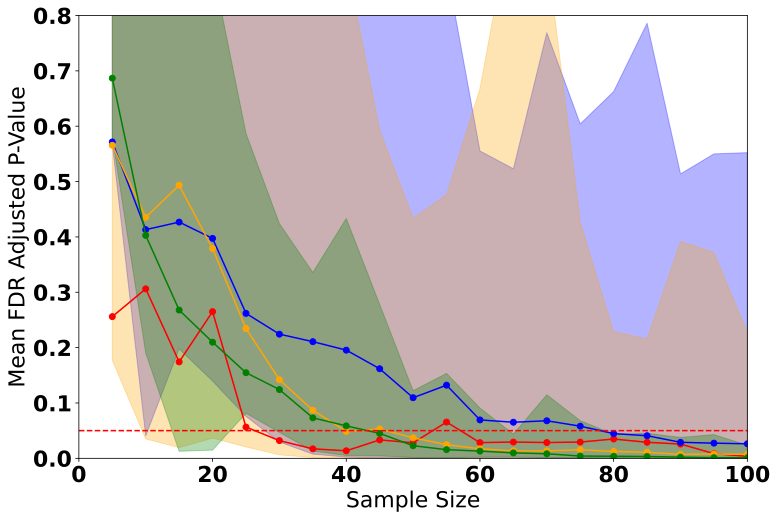

In [17]:
plt.figure(figsize=(12, 8))
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.plot(sample_sizes, real, marker='o', label='Experimental', color='red', linestyle='-')
plt.fill_between(sample_sizes, realmin, realmax, color='red', alpha=0.3)

plt.plot(sample_sizes, pp, marker='o', label='Per-Protein', color='blue', linestyle='-')
plt.fill_between(sample_sizes, ppmin, ppmax, color='blue', alpha=0.3)

plt.plot(sample_sizes, co, marker='o', label='Copula', color='orange', linestyle='-')
plt.fill_between(sample_sizes, comin, comax, color='orange', alpha=0.3)

plt.plot(sample_sizes, tvae, marker='o', label='TVAE', color='green', linestyle='-')
plt.fill_between(sample_sizes, tvaemin, tvaemax, color='green', alpha=0.3)

plt.axhline(y=0.05, color='red', linestyle='--')

plt.xlabel('Sample Size')
plt.ylabel('Mean FDR Adjusted P-Value')

plt.ylim(0.0,0.8)
plt.xlim(0,100)
plt.show()